### Objetivo
Aqui, passamos a analisar os dados coletados para buscar responder as perguntas abaixo.

#### Perguntas
    Variação de preços:
        - Os preços variam durante o dia (price)? 
            - Qual o % de produtos tem preços diferentes ao longo do dia?
            - Para os que tiveram variação, quantas vezes variou?
            - Qual a amplitude de preços dos produtos que tiveram variação?
            - Qual a variação média (olhar o hist)?
            - Há algum horário padrão para mudança nos preços?
         - Quais são os produtos que não tiveram nenhuma variação de preços?
    Descontos:
        - Qual o % de produtos que recebem descontos?
        - Para os que tem desconto, qual o desconto médio (olhar o hist)?
        - A política de desconto é diferente dependedo do preço (gross_price) do produto (gráfico dispersão preço x desconto)?
        - Qual a amplitude do desconto?
        - Dos produtos que tiveram descontos, qtos % tiveram acima de 10%, 20% etc?
        - Quais são os produtos que não tiveram nenhum desconto?
    Frete:
        - Quais produtos não tem frete?
        

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import visualization as vis

plt.style.use('bmh')
%reload_ext autoreload
%autoreload 2

### Carregar os dados

In [201]:
dtype = {'sku': 'object'}
df = pd.read_csv('../../data/dados_consolidados.csv', dtype=dtype)

c_bw = 'purple'
c_sep = 'dimgray'
c_ep = 'lightsalmon'

#### Distribuição dos Preços

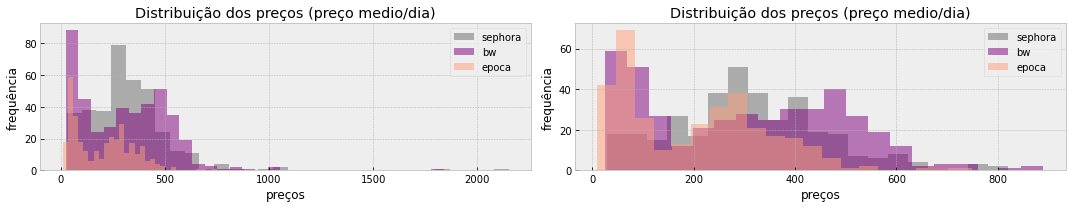

In [139]:
dist_precos = df.groupby(['player', 'sku'])['price'].mean().reset_index()
plt.figure(figsize=(15,3))
vis.hist_precos(dist_precos, bins=30, subplot=121)
vis.hist_precos(dist_precos, bins=20, lim_price=1000, subplot=122)
plt.tight_layout()

> BW e Sephora parecem ter mais produtos com preços maiores, se comparado com a Época. 
> Sephora parece ter mais produtos com preços maiores do que com preços menores, já BW parece ter um portfólio que engloba ambas as faixas de preços. 

> Interessante notar que parece haver um GAP nos preços um pouco menores que 200 reais.

#### - Do total de produtos, quantos % apresentaram algum variação no preço ao longo do dia?

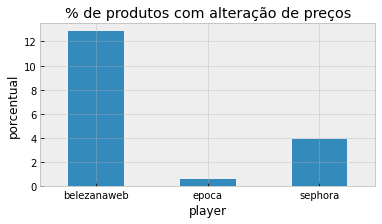

In [140]:
change_prices = df.groupby(['player', 'sku'])['change_price'].agg(sum).astype(int)
(change_prices.apply(lambda x: True if x > 0 else False)
 .groupby('player')
 .mean()
 .multiply(100)
 .round(2)
 .plot
 .bar(title='% de produtos com alteração de preços', figsize=(6,3)))
plt.ylabel("porcentual")
plt.xticks(rotation=0);

#### Para os que tiveram variação, quantas vezes variou?

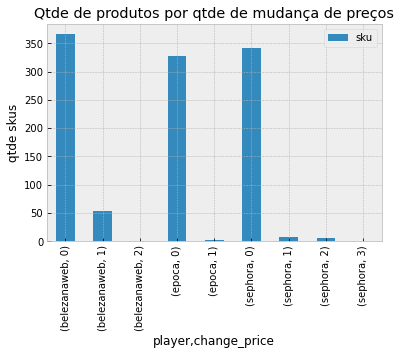

In [141]:
(change_prices
 .reset_index()
 .groupby(['player','change_price'])
 .count()
 .plot
 .bar(title='Qtde de produtos por qtde de mudança de preços', figsize=(6,4)))
plt.ylabel("qtde skus");

#### Qual a amplitude de preços dos produtos que tiveram variação?

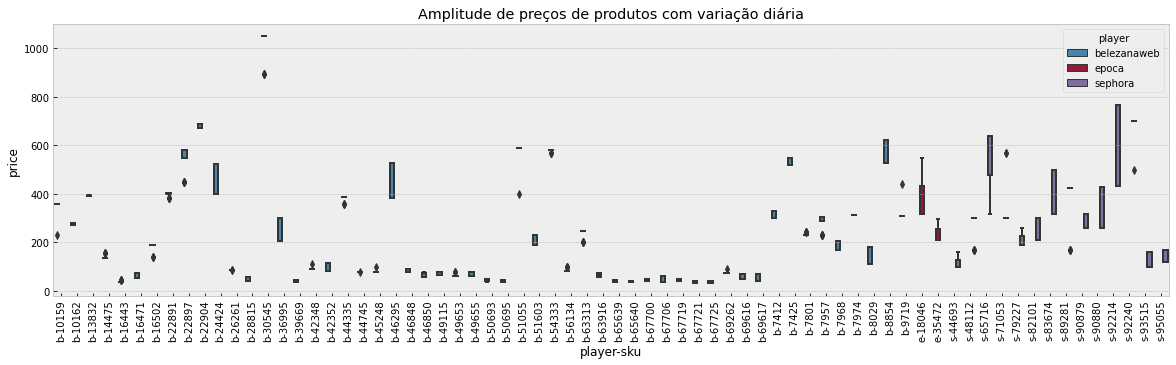

In [142]:
produts_with_change = df.query("change_price > 0")['sku']
df_boxplot = df[df['sku'].isin(produts_with_change)].sort_values(['player', 'sku'])
df_boxplot['player-sku'] = df_boxplot.apply(lambda x: x['player'][0] + "-" + x['sku'], axis=1)
vis.box_amplitude(df_boxplot)

,count,mean,std,min,25%,50%,75%,max
player,,,,,,,,
belezanaweb,54.0,39.0,46.4,1.0,11.0,19.0,37.2,189.0
epoca,2.0,157.5,102.5,85.0,121.2,157.5,193.8,230.0
sephora,14.0,161.0,102.3,50.0,62.8,150.0,242.0,336.0


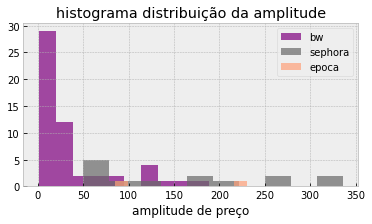

In [143]:
amp = df_boxplot.groupby(['player','sku'])['price'].agg([min,max]).reset_index()
amp['amplitude'] = amp['max']-amp['min']
vis.hist_amplitude(amp)
amp.groupby('player')['amplitude'].describe().astype(float).round(1)

> A BW apresenta mais produtos com alguma alteração de preços ao longo do dia, porém, com amplitude media menor. A Sephora, apesar de apresentar menos produtos com alguma variação no preço (apenas 14), tem uma amplitude média maior, apresentando no maior caso, um amplitude de R$ 336. 

#### Há algum horário padrão para mudança nos preços?

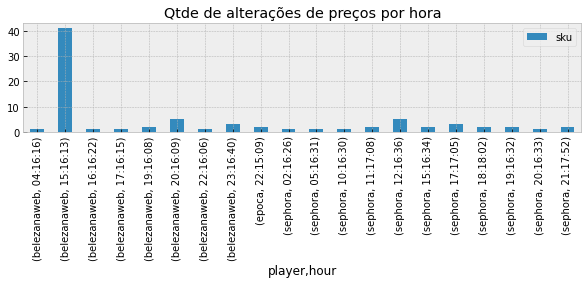

In [144]:
(df
 .query("change_price == True")[['sku','player','hour']]
 .groupby(['player','hour'])
 .count()
 .plot
 .bar(title='Qtde de alterações de preços por hora', figsize=(10,2)));

### Descontos
#### Qual o % de produtos que recebem descontos?

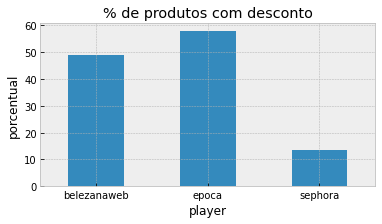

In [145]:
com_desc = df.query("desconto == True")[['player','sku']].drop_duplicates().groupby(['player']).count()
total_skus = df[['player','sku']].drop_duplicates().groupby(['player']).count()
tab_desc = com_desc.merge(total_skus, left_index=True, right_index=True, suffixes=('_com_desc','_total'))
vis.part_desc(tab_desc)

#### Para os que tem desconto, qual o desconto médio (olhar o hist)?

[             count   mean    std    min    25%    50%    75%   max
 player                                                            
 belezanaweb  224.0 -19.22  10.08 -46.39 -25.64 -20.06 -12.31 -0.03
 epoca        192.0 -21.14   9.53 -55.00 -25.00 -18.40 -15.00 -0.05
 sephora       50.0 -21.60   8.65 -40.11 -28.57 -20.31 -15.12 -5.41,
              count   mean    std     min    25%    50%    75%   max
 player                                                             
 belezanaweb  224.0 -48.64  47.25 -216.00 -78.25 -28.50 -12.00  -0.1
 epoca        192.0 -42.34  44.56 -282.01 -60.81 -25.07 -11.00  -0.1
 sephora       50.0 -73.12  40.86 -170.00 -96.75 -71.00 -44.25 -11.0]

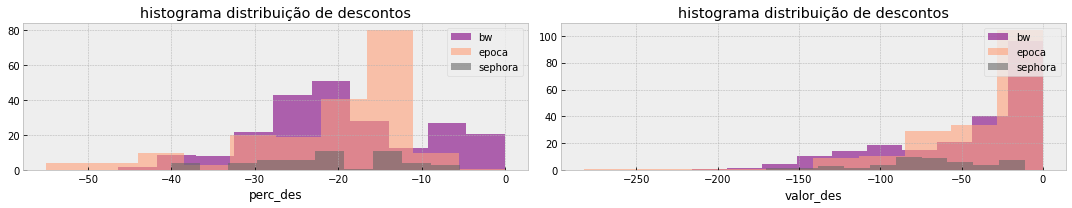

In [160]:
df_descontos = df.query("desconto == True")[['player','sku', 'gross_price','perc_des', 'valor_des']].drop_duplicates()
plt.figure(figsize=(15,3))
vis.dist_descontos(df_descontos, 'perc_des', subplot=121)
vis.dist_descontos(df_descontos, 'valor_des', subplot=122)
plt.tight_layout()
[df_descontos.groupby('player')['perc_des'].describe().astype(float).round(2),
df_descontos.groupby('player')['valor_des'].describe().astype(float).round(2)]

> Sephora oferece desconto para menos produtos (pouco mais de 10% do total). BW e Época apresentam quantidades próximas (para 50% e 60% dos seus produtos).

> Ambos os players oferecem um desconto médio em torno de 20%, mas a Época apresenta, em poucos produtos, decontos mais agressivos.

> A faixa de descontos da Sephora é maior que a dos demais (talvez em produtos mais caros). 

#### Preço x desconto

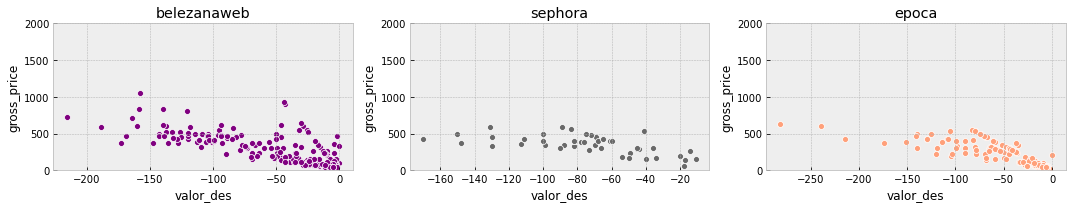

In [200]:
plt.figure(figsize=(15,3))
vis.scatter_price_desc(df_descontos, player='belezanaweb', subplot=131, color=c_bw)
vis.scatter_price_desc(df_descontos, player='sephora', subplot=132, color=c_sep)
vis.scatter_price_desc(df_descontos, player='epoca', subplot=133, color=c_ep)
plt.tight_layout()

### Próximos passos
- Construir uma tabela com DE/PARA para comparar os preços dos mesmos produtos dos 3 websites.
- Tentar entender se o preço de um deles muda quando o preço de algum outro muda.
- Análise de produtos com ou sem frete.
- ...